In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from math import *
from tqdm import tqdm

sources_folder = "data/"

data_sources = [
    # ("R1B7_RvsT_5mV.xlsx", "R1B7_0T_5mV"),
    ("R1B7_RvsT_5mV.xlsx", "R1B7_0T_Coated"),
    # ("R1B9_RvsT_5mV.xlsx", "R_vs_T_R1B92_0T_5mV"),
    ("R1B9_RvsT_coated_0T_5mV.xlsx", "R_vs_T_R1B92_0T_5mV"),
    # ("R2B6_RvsT_5mV.xlsx", "R2B6_0T_5mV"),
    # ("R2B8_RvsT_coated_5mV.xlsx", "R2B8_5mV_0T"),
    # ("R2B9_RvsT_5mV.xlsx", "R2B9_5mV_0T"),
]

data_map = {}

for file, sheet_name in tqdm(data_sources):
    df = pd.read_excel(sources_folder + file, sheet_name=sheet_name)
    # filter out negative currents for fitting purposes
    df = df[df.Current != "--"]
    df = df[df.Current > 0]

    df = df[df.Voltage != "--"]
    df = df[df.Temp != "--"]
    df["Conductance"] = df["Current"] / df["Voltage"]

    data_map[file + ":" + sheet_name] = df


100%|██████████| 2/2 [02:42<00:00, 81.05s/it] 


In [2]:

k_b = 1.380649e-23 #m^2 kg/s^2/K
# force positive fitting coeffs so deriv is positive always
def IV_fit(x, a, b, c, d, f):
    return a * x ** 4 + b * x ** 3 + c * x ** 2 + d * x + f

def plot_IV_curve_simple(file, sheet_name, axs=None, silent=False, voltage_upper_bound=None):
    """
    :param file: Name of the file to read from
    :param sheet_name: Name of the sheet in the file
    :param axs: Optional argument with axs to plot on
    """
    df = pd.read_excel(file, sheet_name=sheet_name)
    df = df.query("Voltage > 0")
    if voltage_upper_bound != None:
        df = df.query("Voltage < {}".format(voltage_upper_bound))
    if silent:
        return df['Voltage'], df['Current']

    if axs == None:
        axs = plt.axes()

    axs.plot(df['Voltage'], df['Current'])
    axs.set_xlabel("Voltage")
    axs.set_ylabel("Current")
    axs.set_title("Voltage-Current curve for {}".format(sheet_name))
    return df['Vsd'], df['Current']


### Temp Conductance ###
def conductance_to_temp_fit(x, a, b, c, d):
    return np.tanh(a * x) * b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)


def fit_cond_to_temp(conductance, temp, offset):
    conds = np.array(conductance) + offset * 1000 / 5
    temp = list(temp)
    temp_out, cond_out = [], []
    for i in range(len(conds)):
        if conds[i] > 0:
            temp_out.append(temp[i])
            cond_out.append(conds[i])


    coeffs, cov = curve_fit(conductance_to_temp_fit, np.array(cond_out),
                            np.array(temp_out)
                            , bounds=((0, 0, 0, 0)
                                      , (np.inf, np.inf, 2, np.inf))
                            , p0=[4e+08, 1.3e+03, 3e-01, 1e+06]
    )
    # default args used to store values and make a closure
    cond_to_temp = lambda x, offset=offset, coeff=coeffs: conductance_to_temp_fit(x+offset * 1000 / 5, *coeff)
    return cond_to_temp, coeffs


# do a binary search, assume f is monotonically increasing
def get_conductance(target_t, f, threshold=0.0001):
    mini = -1
    maxi = 1
    while f(maxi) < target_t:
        maxi *= 2
    while f(mini) > target_t:
        mini *= 2
    center = (mini + maxi) / 2
    while abs(target_t - f(center)) > threshold:
        if f(center) < target_t:
            mini = center
        else:
            maxi = center
        center = (mini + maxi) / 2
    return center


def optimize_current_offset(target_conductance, key, offset=0, threshold=1e-16, adjustment = 1e-10):
    first = True
    last_offset = 1
    last_diff = 0
    diff = 1
    df = data_map[key].copy()
    df["Current"] += offset
    df["Conductance"] = df["Current"] / df["Voltage"]
    df = df.query("Conductance > 0")
    temp, current, voltage, conductance = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]


    while first or abs(offset - last_offset) > threshold:
        adjustment *= 0.95
        first = False

        df = data_map[key].copy()
        df["Current"] += offset
        df["Conductance"] = df["Current"] / df["Voltage"]
        df = df.query("Conductance > 0")
        temp, current, voltage, conductance = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]
        cond_to_temp, coeffs = fit_cond_to_temp(conductance, temp, -offset)


        estimated_temp = cond_to_temp(target_conductance)



        last_diff = diff
        diff = simulation_temperature - estimated_temp

        last_offset = offset

        if diff > 0:
            offset -= adjustment
        else:
            offset += adjustment

        if last_diff * diff < 0:
            adjustment = min(abs(last_offset - offset) / 2, adjustment / 2)
            if abs(offset - last_offset) < 0 * threshold:
                break


        print("Difference: ", diff, "Offset: ", offset)

    return offset, cond_to_temp


# gradient descent until we oscillate between positive and negative then binary search
# with the oscillating values
def optimize_voltage_offset(target_conductance, key, adjustment=3 / 10000, threshold=1e-6):
    first = True
    diff = 1

    # first gradient descent to get near the correct voltage
    offset = 0
    last_diff = 0
    last_offset = 1
    while first or abs(offset - last_offset) > threshold:
        if last_diff * diff < 0:
            adjustment *= .5
        adjustment *= .95
        first = False
        df = data_map[key].copy()
        df["Voltage"] += offset
        df["Conductance"] = df["Current"] / df["Voltage"]
        temp, current, voltage, conductance = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]
        cond_to_temp, _ = fit_cond_to_temp(conductance, temp,0)
        estimated_temp = cond_to_temp(target_conductance)
        last_diff = diff
        diff = simulation_temperature - estimated_temp

        last_offset = offset
        if diff > 0:
            offset += adjustment
        else:
            offset -= adjustment
        print("Distance: ", diff, "Offset: ", offset)
    print("Offset found!!!")

    mini = min(offset, last_offset)  # (setup bounds we just found to binary search)
    maxi = max(offset, last_offset)
    center = (mini + maxi) / 2

    while first or abs(mini - maxi) > threshold:
        first = False
        df = data_map[key].copy()
        df["Voltage"] += center
        df["Conductance"] = df["Current"] / df["Voltage"]
        temp, current, voltage, conductance \
            = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]
        cond_to_temp, _ = fit_cond_to_temp(conductance, temp,0)
        estimated_temp = cond_to_temp(target_conductance)
        diff = simulation_temperature - estimated_temp

        center = (mini + maxi) / 2
        if diff > 0:
            mini = center
        else:
            maxi = center

        print("Distance: ", diff, center)
    return center

# funct is a tuple of domain, range
def interp(x, func):
    domain, outs, *rest = func
    if x < domain[0] or x > domain[-1]:
        raise "x out of bounds of function"
    mini = 0
    maxi = len(domain)
    while maxi-mini > 1:
        center = (mini+maxi)//2
        if x < domain[center]:
            maxi = center
        else:
            mini = center

    m = (outs[maxi]-outs[mini])/(domain[maxi]-domain[mini])
    return m * (x-domain[mini]) + outs[mini]

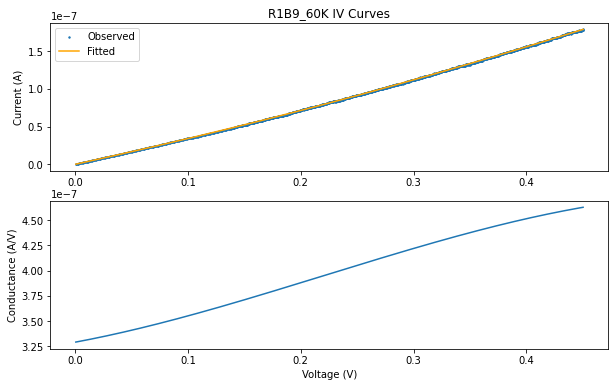

[-2.35195603e-07  2.07018738e-07  1.04182563e-07  3.28951432e-07
  9.25806761e-11]


C:\Users\sfska\AppData\Local\Temp\ipykernel_36836\1410839657.py:31: RuntimeWarning: overflow encountered in exp
  return np.tanh(a * x) * b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)
C:\Users\sfska\AppData\Local\Temp\ipykernel_36836\1410839657.py:31: RuntimeWarning: invalid value encountered in power
  return np.tanh(a * x) * b * np.power(x, c) * np.exp(d * x)  # * (f*x+g)


Conductance offset:  2.8028474901156384e-08
Current offset:  1.4014237450578192e-10
Temperature offset:  2.6201034650683113


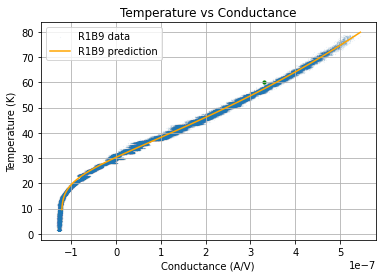

                                            np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)
Coefficients for R1B9                 [3.14560989e+12 5.08118276e+02 1.86184344e-01 1.19323508e+06]


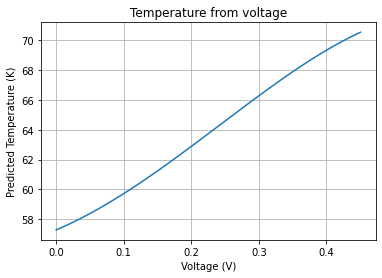

Prediction for 5mV: 57.37989653493169
Prediction for 0.2V: 62.88335237202609


In [3]:
# voltage offsets manually recorded earlier based on original data

# offsets = {
#     "R1B7_100": 0.0007078643081881712,
#     "R1B9_100": 0.0012500504501504822,
#     "R2B8_100": 0.003100873241194125,
#     "R1B9_50": 0,
#
#     "R1B7_150": 0.00048190771431797354,
#     "R1B9_150": 0.001295950435200332,
#     "R2B8_150": 0.003100873241194125
# }


# current offsets
offsets = {
    "R1B9_25":2.8130344977821237e-10,
    "R1B9_30":1.410475762814756e-10,
    "R1B9_50":-2.951370582302791e-10,
    "R1B9_60":-6.090635007484962e-10,
}

cutoff = None
optimizing = False
simulation_temperature = 60
key = ("R1B9_RvsT_coated_0T_5mV.xlsx", "R_vs_T_R1B92_0T_5mV")
key = key[0] + ":" + key[1]
sheet_name = key
short_name = sheet_name[:4]
df = data_map[sheet_name].copy()

# fix the current
current_offset = offsets[short_name+"_"+str(simulation_temperature)]
df["Current"] += current_offset

# print("New avg voltage: {} mV".format(1000 * sum(df["Voltage"]) / len(df["Voltage"])))

df["Conductance"] = df["Current"] / df["Voltage"]
temp, current, voltage, conductance = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]

# sheet_name = short_name + "_0T"
# voltages, currents =   plot_IV_curve_simple(sources_folder
#                          + "IVs_at_{}K-0Tvs7T.xlsx".format(simulation_temperature)
#                          , sheet_name=sheet_name, silent=True,voltage_upper_bound=cutoff)
sheet_name = short_name + ("_{}K".format(simulation_temperature))


# first fit in the 0,10/1000 range
voltages, currents =   plot_IV_curve_simple(sources_folder
                         + "R1B9_R2B8_IV_Curves.xlsx"
                         , sheet_name=sheet_name, silent=True,voltage_upper_bound=10/1000)
p, _ = curve_fit(IV_fit, voltages, currents,
                 bounds=[(0, 0, 0, -np.inf, -np.inf)
                     , (np.inf, np.inf, np.inf, np.inf, np.inf)],
                 p0=[0, 0, 0, 6.57e-07, 4.99e-21])

eps = 1e-20
# next use the linear terms from this fit and add in higher orders
voltages, currents =   plot_IV_curve_simple(sources_folder
                         + "R1B9_R2B8_IV_Curves.xlsx"
                         , sheet_name=sheet_name, silent=True,voltage_upper_bound=cutoff)
p, _ = curve_fit(IV_fit, voltages, currents,
                 bounds=[(-1, -1, -1, p[3]-eps, p[4]-eps)
                     , (1, 1, 1, p[3]+eps, p[4]+eps)],
                 p0=[0, 0, 0, p[3], p[4]])



outputs = np.polyval(p, voltages)
derivs = np.polyder(p)
deriv_outputs = np.polyval(derivs, voltages)

fig, axs = plt.subplots(2, figsize=(10, 6))
axs[0].set_title("{} IV Curves".format(sheet_name))
axs[1].set_xlabel("Voltage (V)")
axs[0].scatter(voltages, currents, s=2, label="Observed")
axs[0].plot(voltages, outputs, color='orange', label="Fitted")
plt.grid()
axs[0].legend()
axs[0].set_ylabel("Current (A)")

axs[1].plot(voltages, deriv_outputs)
axs[1].set_ylabel("Conductance (A/V)")
plt.savefig("graphs/IV Curves and Conductance {} ".format(sheet_name).replace(".xlsx", "").replace(":", "") + str(simulation_temperature))
plt.grid()
plt.show()
print(p)

cond_to_temp, coeffs = fit_cond_to_temp(conductance, temp, -current_offset)

# coeffs = [2.96990012e+08, 1.07357178e+03, 2.33898903e-01, 1.05933656e+06]
# cond_to_temp = lambda x, offset=-500*current_offset, coeff=coeffs: conductance_to_temp_fit(x+offset, *coeff)

plt.figure()
plt.grid()
plt.scatter(conductance, temp, s=.0005, label="{} data".format(short_name))
plt.xlabel("Conductance (A/V)")
plt.ylabel("Temperature (K)")

# calibration_conductance is the expected conductance for 5mV at 100K
# since the two should fit at low voltage (Ohm heating regime)
calibration_conductance = np.polyval(derivs, 5 / 1000)
estimated_conductance = get_conductance(simulation_temperature, cond_to_temp)
print("Conductance offset: ", estimated_conductance - calibration_conductance)
print("Current offset: ", (estimated_conductance - calibration_conductance) * 5 / 1000)
print("Temperature offset: ", simulation_temperature - cond_to_temp(calibration_conductance))

if optimizing:
    offset, _ =  optimize_current_offset(calibration_conductance, key, offset = current_offset)
    print("Current offset to use: ", offset)
    # print("Voltage Offset to use: ", optimize_voltage_offset(calibration_conductance, key))


# plot calibration point
plt.scatter([calibration_conductance], [simulation_temperature], s=10, color='green')
domain = np.linspace(min(conductance), max(max(conductance), calibration_conductance), 1000)
fitted_temps = [cond_to_temp(c) for c in domain]
plt.plot(domain, fitted_temps, color='orange', label="{} prediction".format(short_name))
plt.title("Temperature vs Conductance")
plt.legend()

plt.savefig("graphs/Temperature vs Conductance {} ".format(sheet_name).replace(".xlsx", "").replace(":", "") + str(simulation_temperature))
plt.show()
print(" " * 44 + "np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)")
print("Coefficients for {:<20}".format(short_name), coeffs)

plt.figure()

### now try to compute temperature from a given voltage
# plot voltages from 0 to 1
domain = np.linspace(0, max(voltages), 50000)
conductances = np.polyval(derivs, domain)
temps = cond_to_temp(conductances)
plt.plot(domain, temps)
plt.xlabel("Voltage (V)")
plt.ylabel("Predicted Temperature (K)")
plt.title("Temperature from voltage")
plt.grid()
plt.savefig("graphs/Predicted temperature from voltage {} ".format(short_name) + str(simulation_temperature))
plt.show()

print("Prediction for 5mV: {}".format(cond_to_temp(np.polyval(derivs, 5 / 1000))))
print("Prediction for 0.2V: {}".format(cond_to_temp(np.polyval(derivs, 0.2))))

In [4]:
data = np.load("R1B9 shifted predictions.npy", allow_pickle=True)
data = list(data)
data.append([domain, temps, "60K"])
# for domain, temps, name in data:
#     plt.plot(domain, temps, label = name)
#
# plt.legend()
# plt.grid()
#
# plt.show()




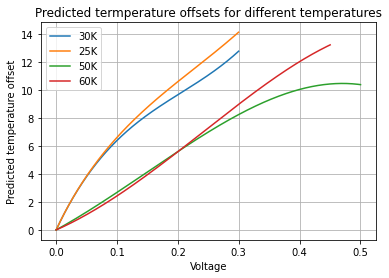

Ratio of predictions: 1.8128273046095658
Ratio of originals: 2.1236510596485223


,Shifted energies,Unshifted energies,Voltage,Current Ratios
0,0.219712,0.194183,0.052,1.078
1,0.121199,0.091438,0.203,1.036


In [8]:
mev_per_J = 6.242e21


data = np.load("R1B9 shifted predictions.npy", allow_pickle=True)
original_len = len(data)
lookup = {}
for domain, outs, name in data:
    plt.plot(domain, outs, label = "{}".format(name))
    lookup[name] = (domain, outs)


if len(data) > original_len:
    np.save("R1B9 shifted predictions.npy", np.array(data))

plt.xlabel("Voltage")
plt.ylabel("Predicted temperature offset")
plt.title("Predicted termperature offsets for different temperatures")
plt.grid()
plt.legend()
plt.savefig("graphs/Comparing temperature offsets across temps")
plt.show()


voltages = np.array([52,203])/1000
current_ratios = np.array([1.078,1.036])
given_temps = np.array([30,30])

given_energies = np.log(current_ratios) * k_b * given_temps * mev_per_J

predicted_temps = np.array([30+interp(x, lookup["30K"]) for x in voltages])
predicted_energies = predicted_temps * k_b * np.log(current_ratios) * mev_per_J
print("Ratio of predictions:", predicted_energies[0]/predicted_energies[1])
print("Ratio of originals:", given_energies[0]/given_energies[1])

pd.DataFrame({"Shifted energies":predicted_energies, "Unshifted energies":given_energies, "Voltage": voltages, "Current Ratios": current_ratios})